In [12]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [15]:
import pandas as pd
import os

In [16]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [17]:
data =  pd.read_csv('magic04.data', sep=",")

In [18]:
X = np.array(data.values[:,:-1])
X = StandardScaler().fit_transform(X)
y = np.array(data.values[:,-1])
y[y=='g']=0
y[y=='h']=1
x_neg = X[:12332]
np.random.shuffle(x_neg)


In [19]:
x_test=x_neg[0:6166]
x_neg_train = x_neg[6166:]
x_pos_train = X[12332:]
x_train = np.concatenate((x_neg_train,x_pos_train))
np.random.shuffle(x_test)
y_train=y[6166:19020].reshape(-1,1).astype(int)
y_test=y[0:6166].reshape(-1,1).astype(float)

# Projection model

In [20]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [21]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [24]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,6000,6000,50,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(6688, 10)
Size: 6000 Bits - FPR: 0.638177 - Time Taken to create filter(sec): 4.419796 



Size: 12000 Bits - FPR: 0.417288 - Time Taken to create filter(sec): 3.327729 



Size: 18000 Bits - FPR: 0.300519 - Time Taken to create filter(sec): 2.184400 



Size: 24000 Bits - FPR: 0.188128 - Time Taken to create filter(sec): 3.594467 



Size: 30000 Bits - FPR: 0.133474 - Time Taken to create filter(sec): 4.321622 



Size: 36000 Bits - FPR: 0.098281 - Time Taken to create filter(sec): 3.896126 



Size: 42000 Bits - FPR: 0.055790 - Time Taken to create filter(sec): 5.644619 



Size: 48000 Bits - FPR: 0.044924 - Time Taken to create filter(sec): 6.047870 



Size: 54000 Bits - FPR: 0.031301 - Time Taken to create filter(sec): 6.137172 



Size: 60000 Bits - FPR: 0.019624 - Time Taken to create filter(sec): 6.922049 



Size: 66000 Bits - FPR: 0.017678 - Time Taken to create filter(sec): 6.138933 



Size: 72000 Bits - FPR: 0.008596 - Time Taken to create 

Size: 294000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 23.570202 



Size: 300000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 24.223416 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

(6688, 10)
Size: 6000 Bits - FPR: 0.640448 - Time Taken to create filter(sec): 3.839652 



Size: 12000 Bits - FPR: 0.405774 - Time Taken to create filter(sec): 3.641654 



Size: 18000 Bits - FPR: 0.312520 - Time Taken to create filter(sec): 3.651869 



Size: 24000 Bits - FPR: 0.186182 - Time Taken to create filter(sec): 3.741594 



Size: 30000 Bits - FPR: 0.107687 - Time Taken to create filter(sec): 4.171687 



Size: 36000 Bits - FPR: 0.083198 - Time Taken to create filter(sec): 3.878727 



Size: 42000 Bits - FPR: 0.051087 - Time Taken to create filter(sec): 5.600086 



Size: 48000 Bits - FPR: 0.040383 - Time Taken to create filter(sec): 5.573509 



Size: 54000 Bits - FPR: 0.042978 - Time Taken to create filter(sec): 6.169875 



Size: 60000 Bits - FPR: 0.017678 - Time Taken to cre

In [25]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

50


In [26]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

50


# Normal Bloom Filter Values

In [27]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [28]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

150
[6688]


# FPR Comparison between Projection Model and Normal Bloom Filter

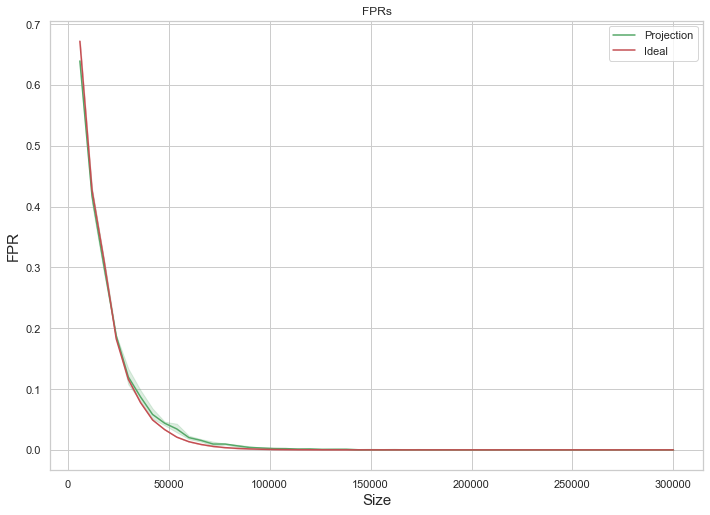

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [30]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

150


In [31]:
average_times = num_of_iterations*average_times
print(len(average_times))

150


In [32]:
print(average_fprs)

[0.6394745377878689, 0.41788301437993297, 0.3009514542112661, 0.1876419072332144, 0.11995891447724077, 0.08730673586333658, 0.058276570440047575, 0.04384257757595416, 0.034382095361660724, 0.020164342091036867, 0.015569250729808628, 0.009568602011028219, 0.009568602011028219, 0.00659530760082171, 0.003946372580819548, 0.003081414206941291, 0.002216455833063034, 0.002054276137960861, 0.0012974375608173856, 0.00151367715428695, 0.0008649583738782571, 0.0009730781706130393, 0.0010271380689804302, 0.0001621796951021732, 0.0002702994918369553, 0.0001621796951021732, 0.0002702994918369553, 0.00010811979673478214, 0.00021623959346956428, 5.405989836739107e-05, 0.00010811979673478214, 0.0, 0.0, 0.0, 0.0, 5.405989836739107e-05, 0.0, 0.0, 5.405989836739107e-05, 5.405989836739107e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 5.405989836739107e-05, 0.0, 0.0, 0.0, 0.0, 0.6394745377878689, 0.41788301437993297, 0.3009514542112661, 0.1876419072332144, 0.11995891447724077, 0.08730673586333658, 0.058276570440047575, 0.

In [33]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,6000,0.672006,0.638177,0.639475,4.419796,3.982186
1,12000,0.427279,0.417288,0.417883,3.327729,3.545459
2,18000,0.310346,0.300519,0.300951,2.184400,3.125168
3,24000,0.182562,0.188128,0.187642,3.594467,3.610864
4,30000,0.115988,0.133474,0.119959,4.321622,4.147038


In [34]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Magic_rerun_epochs_100.csv')